# Assignment 2 - Lending Club
## Oscar Engelbrektson
## CS156, Prof. Albrecht, Fall 2019

In [558]:
import pandas as pd
import pandas_profiling as pp
import numpy as np

In [559]:
accept_df = pd.read_csv("/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/lending-club/accepted_2007_to_2018Q4.csv", low_memory=False)

In [560]:
reject_df = pd.read_csv("/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/lending-club/rejected_2007_to_2018Q4.csv", low_memory=False)

In [561]:
print(reject_df.shape)
reject_df.head()

(27648741, 9)


,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [562]:
print(accept_df.shape)
accept_df.head()

(2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Pre-processing

The pre-processing of the lending club data set consists of four sections: 
1. Extracting a subset of the data. The dataset is too large for my laptop to work with. I will hence need to extract a subset of the data in each dataset. Working on the assumption that recent data is preferable to older data for the purposes of prediction, I will make a hard cutoff at the beginning of 2018. This means I will have one years worth of data for both rejected and accepted. However, this still leaves me with several million observations in each dataset–too many. The number of observations in each dataset is approximately equal over this time period, I will therefore randomly sample an equal number, 150 000, of observations from each data set.
    1. Extract 2018
    2. Remove Rows with Nan observations in relevant columns (determined in 2.)
    3. Randomly sample 150 000 observations from each data set
2. Column selection. For the purposes of predicting the what loan ammount will be accepted ahead of time, only the data which are known at the time of application submission are of interest. Consequently, all other columns will be dropped. Furthermore, the predictive approach I am taking here is fitting a logistic regression with whther or not a loan gets funded as the outcome variable. Thus, I can only include columns which represent information present in both the reject_df and accept_df. Otherwise, the columns will contribute any meaningful information in predicting the outcome of interest. That is, if a binary variable is only observed if the loan is successfully funded, then there will be perfect collinearity between the outcome and the variable. 
3. Merging the accepted dataset with the rejected dataset.
4. Column pre-processing. Converting each column into a representation that is amenable to model fitting. E.g. making one-hot encodings for unordered categorical variables.

##  1.  Extracting a subset of the data

#### Extracting 2018

In [563]:
#Find the latest date for which values are observed in both datasets
#This will be the upper bound of our time subset

#Convert to datetime
reject_df["Application Date"] = pd.to_datetime(reject_df["Application Date"])
accept_df["issue_d"] = pd.to_datetime(accept_df["issue_d"])

In [564]:
#Application date, the only date value in the reject_df
reject_df["Application Date"] = pd.to_datetime(reject_df["Application Date"])
reject_df = reject_df.loc[(reject_df['Application Date'] > np.datetime64("2017-12-31 23:59:59")) & 
                         (reject_df['Application Date'] <= np.datetime64("2019-01-01 00:00:00"))]

#issue date is the only date value in the accept_df, 
#given low processing times for loan applications we take this to be approximately the same as the application date
accept_df = accept_df.loc[(accept_df["issue_d"] > np.datetime64("2017-12-31 23:59:59")) & 
                         (accept_df["issue_d"] <= np.datetime64("2019-01-01 00:00:00"))]

#### Drop rows with missing values on relevant columns

In [565]:
list(reject_df)

['Amount Requested',
 'Application Date',
 'Loan Title',
 'Risk_Score',
 'Debt-To-Income Ratio',
 'Zip Code',
 'State',
 'Employment Length',
 'Policy Code']

In [566]:
accept_df.dropna(subset=["loan_amnt", 
                        "issue_d", 
                        "title", "dti", 
                        "addr_state", 
                        "emp_length", 
                        "policy_code"], inplace=True)

reject_df.dropna(subset=['Amount Requested',
                         'Application Date',
                         'Loan Title',
                         'Risk_Score',
                         'Debt-To-Income Ratio',
                         'Zip Code',
                         'State',
                         'Employment Length',
                         'Policy Code'], inplace=True)

#### Sampling 150 000 observations

In [567]:
sample_size = 150000
reject_df = reject_df.sample(n=sample_size, random_state=1)
accept_df = accept_df.sample(n=sample_size, random_state=1)

## 2. Column Selection

#### Removing columns observed after funding decisions have been made or are not present in both datasets

In [568]:
#All columns in reject_df are observed before or at the time of funding decisions, we keep all
#However, we drop risk score and policy code because no corresponding columns exist in accept_df
reject_df.drop(columns = ["Risk_Score"], inplace=True)

accept_df = accept_df[["loan_amnt", "funded_amnt", "funded_amnt_inv", 
                       "issue_d", "title", "dti", "zip_code", 
                       "addr_state", "emp_length", "policy_code"]]

#### Decide if it makes sense to keep loan_amnt, funded_amnt and funded_amnt_inv

In [569]:
#Make correlation table of variables
accept_df[["loan_amnt", "funded_amnt", "funded_amnt_inv"]].corr(method="pearson")

,loan_amnt,funded_amnt,funded_amnt_inv
loan_amnt,1.000000,1.000000,0.999996
funded_amnt,1.000000,1.000000,0.999996
funded_amnt_inv,0.999996,0.999996,1.000000


In [570]:
#The variables are almost perfectly collinear, thus I will keep only one of them. 
#I select loan_amnt, which is identical to funded_amnt, because it represents the requested amount 
#(present in rejected_df).
accept_df.drop(columns=["funded_amnt", "funded_amnt_inv"], inplace=True)

In [571]:
accept_df.head()

,loan_amnt,issue_d,title,dti,zip_code,addr_state,emp_length,policy_code
1376235,1500.0,2018-12-01,Debt consolidation,18.67,379xx,TN,1 year,1.0
525943,7000.0,2018-01-01,Car financing,32.58,391xx,MS,4 years,1.0
1442708,9000.0,2018-10-01,Debt consolidation,16.94,760xx,TX,10+ years,1.0
433916,24000.0,2018-03-01,Major purchase,0.00,594xx,MT,10+ years,1.0
435591,3000.0,2018-03-01,Credit card refinancing,12.83,480xx,MI,< 1 year,1.0


In [661]:
accept_df.loan_amnt.describe()

count    150000.000000
mean      16308.819000
std       10207.713648
min        1000.000000
25%        8500.000000
50%       14400.000000
75%       22825.000000
max       40000.000000
Name: loan_amnt, dtype: float64

In [663]:
reject_df.columns

Index(['loan_amnt', 'date', 'loan_title', 'dti', 'zip_code', 'state',
       'emp_length', 'policy_code', 'funded'],
      dtype='object')

In [664]:
reject_df.loan_amnt.describe()

count    150000.000000
mean      11366.542833
std       10630.050884
min        1000.000000
25%        3000.000000
50%        8000.000000
75%       15500.000000
max       90725.000000
Name: loan_amnt, dtype: float64

In [572]:
reject_df.head()

,Amount Requested,Application Date,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
9730655,5000.0,2018-01-03,Credit card refinancing,11.74%,223xx,VA,< 1 year,0.0
16468121,10000.0,2018-12-03,Car financing,0%,238xx,VA,< 1 year,0.0
9706290,25000.0,2018-01-02,Debt consolidation,29.25%,364xx,AL,< 1 year,0.0
17209960,3975.0,2018-12-29,Other,7.26%,770xx,TX,< 1 year,0.0
9875772,13000.0,2018-01-09,Credit card refinancing,29.03%,014xx,MA,< 1 year,0.0


## 3. Merging the dataframes

#### We begin by renaming the columns to match to match accross the datasets

In [573]:
#Modifying the Reject column names
reject_df.rename(columns={"Amount Requested": "loan_amnt", "Application Date":"date", 
                 "Loan Title": "loan_title", "Debt-To-Income Ratio": "dti",
                "Zip Code":"zip_code", "State":"state", 
                 "Employment Length":"emp_length", "Policy Code":"policy_code"}, inplace=True)

#Modifying the accept column names
accept_df.rename(columns={"issue_d":"date", "addr_state":"state", 
                          "title":"loan_title"}, inplace=True)

#### Add binary variable, accepted, indicating whether loan was successfully funded or not

In [574]:
#1 for all observations in accepted_df
accept_df["funded"] = 1

#0 for all observations in the reject_df
reject_df["funded"] = 0

#### Concatenate the dataframes

In [575]:
#Before concatenating, remove the # from dti in the rejected data
reject_df.loc[:,['dti']] = np.array([x.replace('%','') for x in reject_df["dti"]])

In [576]:
loan_df = pd.concat([accept_df, reject_df], sort=False)

In [577]:
loan_df

,loan_amnt,date,loan_title,dti,zip_code,state,emp_length,policy_code,funded
1376235,1500.0,2018-12-01,Debt consolidation,18.67,379xx,TN,1 year,1.0,1
525943,7000.0,2018-01-01,Car financing,32.58,391xx,MS,4 years,1.0,1
1442708,9000.0,2018-10-01,Debt consolidation,16.94,760xx,TX,10+ years,1.0,1
433916,24000.0,2018-03-01,Major purchase,0,594xx,MT,10+ years,1.0,1
435591,3000.0,2018-03-01,Credit card refinancing,12.83,480xx,MI,< 1 year,1.0,1
...,...,...,...,...,...,...,...,...,...
9809266,7000.0,2018-01-06,Credit card refinancing,47.09,890xx,NV,< 1 year,0.0,0
10030958,10000.0,2018-01-17,Debt consolidation,58.42,790xx,TX,< 1 year,0.0,0
9946061,35000.0,2018-01-12,Other,4.94,755xx,TX,< 1 year,0.0,0
9866939,10000.0,2018-01-09,Credit card refinancing,41.91,540xx,WI,< 1 year,0.0,0


# 4. Pre-processing variables to regressable format

#### loan_amnt
Nicely formatted, all entries are numerical

#### date
We cannot reasonably expect the date to contain anything but noise about whether or not a loan becomes funded. E.g. we don't want the model to learn that it is really hard to get loans approved in February 2018.
Perhaps if we performed some pre-processing, e.g. extracting the month or weekday we could see some seasonality effects. However, as predictive accuracy is not the purpose of this assignment, I choose to exclude date alltogether.

In [578]:
loan_df.drop(columns=["date"], inplace=True)

#### loan_title
loan_title is an unordered categorical variable, make indicator variable for each value

In [579]:
loan_df["loan_title"].value_counts()

Debt consolidation         136494
Credit card refinancing     58812
Other                       48310
Home improvement            13062
Car financing               10924
Major purchase               7478
Home buying                  6600
Medical expenses             6557
Moving and relocation        5367
Business                     3762
Vacation                     2323
Green loan                    301
Learning and training          10
Name: loan_title, dtype: int64

In [580]:
#Using the same division scheme as the above output, I will create a dummy variable for each using pd.get_dummies
one_hot = pd.get_dummies(loan_df["loan_title"])

#add onehot encoding to df
loan_df = loan_df.join(one_hot)

#drop loan_title
loan_df.drop('loan_title',axis = 1, inplace=True)

In [581]:
loan_df

,loan_amnt,dti,zip_code,state,emp_length,policy_code,funded,Business,Car financing,Credit card refinancing,Debt consolidation,Green loan,Home buying,Home improvement,Learning and training,Major purchase,Medical expenses,Moving and relocation,Other,Vacation
1376235,1500.0,18.67,379xx,TN,1 year,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
525943,7000.0,32.58,391xx,MS,4 years,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1442708,9000.0,16.94,760xx,TX,10+ years,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
433916,24000.0,0,594xx,MT,10+ years,1.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
435591,3000.0,12.83,480xx,MI,< 1 year,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9809266,7000.0,47.09,890xx,NV,< 1 year,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10030958,10000.0,58.42,790xx,TX,< 1 year,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9946061,35000.0,4.94,755xx,TX,< 1 year,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9866939,10000.0,41.91,540xx,WI,< 1 year,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


#### dti
All "%" are already removed. Now make all entries numerical.

In [582]:
loan_df["dti"] = pd.to_numeric(loan_df["dti"])

#### zip_code
Remove: the valuable information is contained in state.

In [583]:
loan_df.drop('zip_code',axis = 1, inplace=True)

#### state
state is an unordered categorical variable, make indicator variable for each value

In [584]:
onehot = pd.get_dummies(loan_df["state"])

#add onehot encoding to df
loan_df = loan_df.join(onehot)

#drop state
loan_df.drop('state',axis = 1, inplace=True)

#### emp_length
emplyment length is an ordered categorical variable. Since there is approx.1 year between each category, I will simply use the year number as the value for this variable. To do this, I remove everything except the number indicating the year from each variable. I round <1 to 0.

In [585]:
loan_df["emp_length"].value_counts()

< 1 year     155059
10+ years     54866
2 years       15813
3 years       14607
1 year        12896
5 years       11974
4 years       10893
6 years        7507
7 years        6141
8 years        5840
9 years        4404
Name: emp_length, dtype: int64

In [586]:
#Not pretty but fast to code:

#Start by removing "year"
loan_df.loc[:,['emp_length']] = np.array([x.replace('year','') for x in loan_df['emp_length']])

#If it originally said "years", it now says "s" -> Remove "s"
loan_df.loc[:,['emp_length']] = np.array([x.replace('s','') for x in loan_df['emp_length']])

#From "<1" remove "<"
loan_df.loc[:,['emp_length']] = np.array([x.replace('<','') for x in loan_df['emp_length']])

#From "+10" remove "+"
loan_df.loc[:,['emp_length']] = np.array([x.replace('+','') for x in loan_df['emp_length']])

#Convert to numerical
loan_df['emp_length'] = pd.to_numeric(loan_df['emp_length'])

In [587]:
loan_df["emp_length"].value_counts()

1     167955
10     54866
2      15813
3      14607
5      11974
4      10893
6       7507
7       6141
8       5840
9       4404
Name: emp_length, dtype: int64

#### policy_code

We drop policy code because it is correlated with the outcome variable.

In [588]:
loan_df.drop(columns=["policy_code"], inplace=True)

# Model fitting and evaluation

## Splitting data into training and test sets

In [616]:
#Outcome variable
y = loan_df["funded"]

#Predictor variables, all except the outcome variable
X = loan_df.loc[:, loan_df.columns != 'funded']

In [590]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2)

In [591]:
#shape of train and test objects
print(X_train.shape)
print(X_test.shape)

(270000, 67)
(30000, 67)


In [592]:
# shape of new y objects
print(y_train.shape)
print(y_test.shape)

(270000,)
(30000,)


## Model selection

My approach to building a model that predicts the largest loan amount that will be successfully funded for given individual that can then be used to advise applicants on how much they could apply for, will use logistic regression. The idea is this, I will train a logistic regression with "funded" as the outcome variables, using the remaining variables as predictors. The output of the logistic regression, bounded on the range 0 and 1, can be interpreted as the probability that the a loan application will be accepted given the applicants application profile. Consequently, the model can be used to predict the maximum loan that will be granted by the following method:
1. For any given applicant, all covariates are fixed. For example, they come from a certain state and no other etc. With the exception of the loan amount.
2. Using the logistic regression model to make predictions, we hold all covariates fixes, varying the loan amount. We can then predict the probability that certain applicant will have his loan application successfully funded as a function of the loan amount he requests. 
3. Because the model is linear in the parameters, a negative coefficient on the loan amount will mean that the probability of getting a loan funded is strictly decreasing with the loan amount. Consequently, we select some desired probability of getting the loan funded, e.g. 99%, and then increase the loan amount until the desired probability is reached. We define this loan value to be the "largest loan amount" a certain applicant can expect to get funded, given his certainty contraints.

To fit the model:
1. We use cross validation to select the best regularization parameter c.
2. We then fit the model using the best c on all the training data.
3. We evaluate performance on the test set
4. We then train the model on all the data, and define a function for predicting the maximimum value.

In [593]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [594]:
#Try running from c=1 through 25 and record testing accuracy
c_values = [0.001,0.01,0.1,1,10,100]
scores = {}
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []


for k in c_values:
    model = LogisticRegression(C=k, solver="lbfgs", max_iter=1000)
    cv_results = cross_validate(model, X_train, y_train,
                            scoring=['accuracy', "precision", "recall", "f1"], cv=5)
    
    #Store average accuracy accross the five splits
    accuracy_list.append(np.mean(cv_results['test_accuracy']))
    precision_list.append(np.mean(cv_results['test_precision']))
    recall_list.append(np.mean(cv_results['test_recall']))
    f1_list.append(np.mean(cv_results['test_f1']))

## Plotting test performance metrics for each C

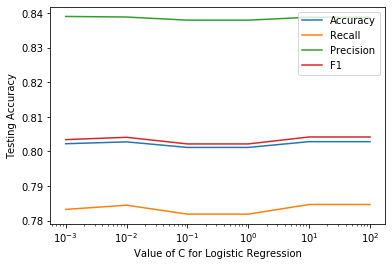

In [595]:
import matplotlib.pyplot as plt
%matplotlib inline

#Using a loged x-axis as the c values differ by an order of magnitude each
plt.semilogx(c_values, accuracy_list, label="Accuracy")
plt.semilogx(c_values, recall_list, label="Recall")
plt.semilogx(c_values, precision_list, label="Precision")
plt.semilogx(c_values, f1_list, label="F1")
plt.legend(loc=0)
plt.xlabel('Value of C for Logistic Regression')
plt.ylabel('Testing Accuracy')
plt.show()

# Evaluating performance on the test set

In [602]:
#Selecting c=0.1 as it has the highest value for all performance estimators,
#and training on the entire training set
model = LogisticRegression(C=0.01, solver="lbfgs", max_iter=1000)
model.fit(X_train,y_train)

#Making prediction on the unseen test data
y_pred=model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.7146666666666667


In [666]:
loan_df[loan_df.funded ==1].loan_amnt.describe()

count    150000.000000
mean      16308.819000
std       10207.713648
min        1000.000000
25%        8500.000000
50%       14400.000000
75%       22825.000000
max       40000.000000
Name: loan_amnt, dtype: float64

In [667]:
loan_df[loan_df.funded ==0].loan_amnt.describe()

count    150000.000000
mean      11366.542833
std       10630.050884
min        1000.000000
25%        3000.000000
50%        8000.000000
75%       15500.000000
max       90725.000000
Name: loan_amnt, dtype: float64

In [627]:
#Reviewing the coefficients of the table.

#We see that the loan amount has a negative coefficient, 
#agreeing with out intuition that, all else constant, 
#higher loans amounts correspond to lower chances of successfully funding
model.coef_

array([[-1.35144501e-05, -3.74733950e-02,  4.86620750e-01,
        -1.02062917e-03, -6.25858191e-03,  1.30229466e-02,
         8.73433919e-03, -1.11395400e-04, -3.27424337e-03,
         4.42538027e-03, -6.73495709e-06, -8.21693687e-04,
        -2.07842779e-03, -2.75893067e-03, -2.23140217e-02,
         2.94259994e-05, -5.71520180e-05, -8.14596947e-04,
        -4.29896703e-04,  1.17397980e-04,  7.26149661e-04,
         3.28462153e-04,  2.60701266e-04, -6.58498795e-05,
        -3.36474057e-05, -1.52728667e-03, -1.35975570e-03,
        -2.37012729e-04, -2.07898724e-06, -9.98264027e-05,
         1.26098260e-04, -5.34433006e-04, -9.67015866e-05,
        -5.24520389e-04, -7.49554115e-04, -7.38097036e-05,
        -1.94332016e-04, -4.91229659e-05, -4.45858050e-04,
         1.80918831e-04, -3.05866583e-04, -8.51080299e-04,
         2.40311079e-05, -8.26279565e-04, -5.11651663e-05,
        -1.72099540e-05,  1.05886733e-04,  9.64136908e-05,
        -1.36807176e-04,  2.64623224e-04,  1.13225362e-0

## Predicting the maximum loan amount for some person

Normally I would run the agreed upon model on all the data before doing predictions, as more date is preferable to less for prediction tasks. However, I save the test individuals to use as examples for the prediction task.

In [670]:
def loan_probabilities(x):
    '''
    Takes index of person in test set,
    Returns two lists, one showing the loan amounts and a second list
    showing the corresponding probability of funding at the corresponding index
    '''
    #Taking the first person in the test set
    test_person = np.array(X_test.iloc[x]).reshape(1, -1)
    test_person.reshape(1,67)

    loan_amnt_list = []
    probabilities_list = []
    for i in range(179):
            loan_amnt = 1000+500*i
            loan_amnt_list.append(loan_amnt)

            #Update the loan amount
            test_person[0][0] = loan_amnt

            #Predict probability of successfully funded, given loan amount
            probabilities_list.append(model.predict_proba(test_person)[0][1])
    
    return loan_amnt_list, probabilities_list

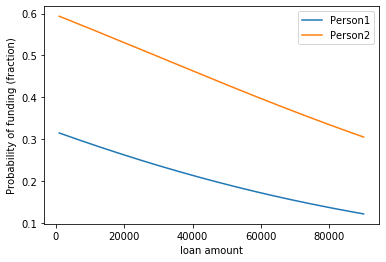

In [671]:
loan_amnt_list, probabilities_list0 = loan_probabilities(0)
loan_amnt_list, probabilities_list1 = loan_probabilities(1)

#Using a loged x-axis as the c values differ by an order of magnitude each
plt.plot(loan_amnt_list, probabilities_list0, label="Person1")
plt.plot(loan_amnt_list, probabilities_list1, label="Person2")
plt.legend(loc=0)
plt.xlabel('loan amount')
plt.ylabel('Probability of funding (fraction)')
plt.show()

The above figure illustrates the probability for the two first people in the dataset to have his loan successfully funded as a function of the loan size. This is thus an example of the procedure defined above. It doesn't seem this particular individual is very likeli to get a loan regardless of the loan amount, the second person is much more likely to get the loan approved for any loan size. Adjusting the loan sizes in the function above, this could be a useful visual tool to help consumers inform themselves about what is a suitable loan size for them. Incorporating an x-line that shows at what loan amount the probbility of success reaches a certain, user chosen, threshhold would make it even more helpful.

In [ ]:
X = loan_df["loan_amnt"]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2)

In [668]:
#Selecting c=0.1 as it has the highest value for all performance estimators,
#and training on the entire training set
model = LogisticRegression(C=0.01, solver="lbfgs", max_iter=1000)
model.fit(X_train,y_train)

#Making prediction on the unseen test data
y_pred=model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.7146666666666667
